<a href="https://colab.research.google.com/github/SalihTasdelen/remin/blob/main/example_heat_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install remin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=c6c822fd40909270ecff60a958eeda247a489c1428b0cbbd7d1a3a0cce0ee6e1
  Stored in directory: /root/.cache/pip/wheels/3c/ca/0d/63b767ad585fbcb3ea222541572dcb78859d0383510672b105
Successfully built pyDOE


In [3]:
from remin import Residual, Solver
from remin import func
import torch
from torch import nn
import numpy as np
from pyDOE.doe_lhs import lhs
import matplotlib.pyplot as plt
from matplotlib import cm

torch.set_default_device('cuda')

In [4]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
    
    def forward(self, t, x):
        xs = torch.hstack((t, x))
        return self.linear_sigmoid_stack(xs)
    
model = NeuralNet()

In [5]:
u = func.functional_call(model)
u_t = func.grad(u, argnum=1)
u_x = func.grad(u, argnum=2)
u_xx = func.grad(u_x, argnum=2)

In [6]:
def pde_residual(params, t, x):
    return u_t(params, t, x) - 0.05*u_xx(params, t, x)

def ic_residual(params, t, x):
    return u(params, t, x) - torch.tensor(20.0)

def bc_residual(params, t, x):
    return u(params, t, x) - torch.tensor(0.0)

In [8]:
pde_domain = torch.from_numpy(lhs(2, 100)).type(torch.float32).cuda(0)
ic_domain = torch.from_numpy(np.array([0, 1]) * lhs(2, 100)).type(torch.float32).cuda(0)
bc0_domain = torch.from_numpy(np.array([1, 0]) * lhs(2, 100)).type(torch.float32).cuda(0)
bc1_domain = torch.from_numpy(np.array([1, 0]) * lhs(2, 100) + np.array([0,1])).type(torch.float32).cuda(0)

pde_res = Residual(pde_domain, pde_residual)
ic_res = Residual(ic_domain, ic_residual)
bc0_res = Residual(bc0_domain, bc_residual)
bc1_res = Residual(bc1_domain, bc_residual)

In [9]:
epochs = 35000
lr = 2e-4

heat = Solver(model, [pde_res, ic_res, bc0_res, bc1_res])
lossfunc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
heat.compile(optimizer, lossfunc, backend='inductor', fullgraph=True)

In [10]:
heat.fit(epochs, log_epoch=1000)
heat.save('heat.pt')

Loss: 410.1300048828125  [    0/35000]
Loss: 214.6432342529297  [ 1000/35000]
Loss: 47.460693359375  [ 2000/35000]
Loss: 8.885519027709961  [ 3000/35000]
Loss: 4.407224178314209  [ 4000/35000]
Loss: 3.451920747756958  [ 5000/35000]
Loss: 2.860142230987549  [ 6000/35000]
Loss: 2.4528939723968506  [ 7000/35000]
Loss: 2.228801727294922  [ 8000/35000]
Loss: 1.9015940427780151  [ 9000/35000]
Loss: 1.7107092142105103  [10000/35000]
Loss: 1.6767675876617432  [11000/35000]
Loss: 1.4207905530929565  [12000/35000]
Loss: 1.3034006357192993  [13000/35000]
Loss: 1.2177544832229614  [14000/35000]
Loss: 1.1255611181259155  [15000/35000]
Loss: 1.0377436876296997  [16000/35000]
Loss: 0.9617611169815063  [17000/35000]
Loss: 0.892495334148407  [18000/35000]
Loss: 0.8252823948860168  [19000/35000]
Loss: 0.7794008851051331  [20000/35000]
Loss: 0.7216809391975403  [21000/35000]
Loss: 0.6574208736419678  [22000/35000]
Loss: 0.6433894038200378  [23000/35000]
Loss: 0.5266739130020142  [24000/35000]
Loss: 0.471

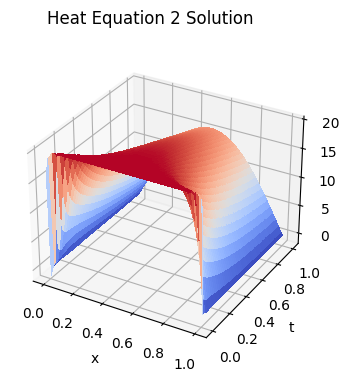

In [13]:
t = torch.linspace(0, 1, 100)#.reshape((100,1))
x = torch.linspace(0, 1, 100)#.reshape((100,1))
T, X = torch.meshgrid(t, x)

z_predict = torch.hstack([model(T[:,i:i+1], X[:,i:i+1]) for i in range(T.shape[1])])

fig, ax1 = plt.subplots(1,1,subplot_kw={'projection': '3d'})
fig.set_size_inches(11, 4)
fig.suptitle('Heat Equation 2 Solution')

ax1.set(xlabel='x', ylabel='t', zlabel='u')

surf = ax1.plot_surface(X.detach().cpu(), T.detach().cpu(), z_predict.detach().cpu(), linewidth=0, antialiased=False, cmap=cm.coolwarm)